In [62]:
#Ativar o autocomplete
%config IPCompleter.greedy=True

In [63]:
import zipfile
import json
import pandas as pd
from functools import reduce
import os
from IPython.display import display, HTML
from pathlib import Path
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
#import pyautogui
import base64
from math import ceil
import re

In [64]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [65]:
#Função para conseguir visualizar o DataFrame completo
def display_df(df, show_index=True):
    display(HTML(df.to_html(index=show_index)))

In [66]:
def json_extract(obj, key):
    """Recursively fetch values from nested JSON."""
    arr = []

    def extract(obj, arr, key):
        """Recursively search for values of key in JSON tree."""
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr, key)
                elif k == key:
                    arr.append(v)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)
        return arr

    values = extract(obj, arr, key)
    return values

In [67]:
#Função para extrair dados do arquivo json e adicionar na lista.
#Preenche a lista com None quando não há dados para a chave.
def list_append(obj, key, list):
    extracted_data = json_extract(obj, key)
    if not extracted_data:
        list.append(None)
    else:
        list.append(extracted_data[0])

In [68]:
#Função para extrair dados específicos do evento PROJECT_CHANGED
#Retorna uma lista com todos o branches, uma lista com as variáveis utilizadas no dataviewer e uma lsita com os nomes dos blocos
def project_data_extract(obj):
    branches = []
    dataviewer_getValue_lists = []
    blocks_names = []
    extensions = []
    if 'project' in obj:
        lists = {}
        for stage_actors in obj['project']['targets']:
            if stage_actors['lists']:
                for listID, details in stage_actors['lists'].items():
                    lists[listID] = details[0]

        speed = {4: 'high', 2: 'medium', 1: 'low', 0: 'zero'}
        blocks = []
        for stage_actors in obj['project']['targets']:
            if stage_actors['blocks']:
                for blockID, details in stage_actors['blocks'].items():
                    if isinstance(details, dict) and details['shadow'] == False:
                        blockName = details['opcode']
                        blocks_names.append(blockName)
                        if 'LIST_ID' in details['fields']:
                            listID = details['fields']['LIST_ID'][0]
                            if listID in lists:
                                if blockName == 'dataviewer_getValue' and lists[listID] not in dataviewer_getValue_lists:
                                    dataviewer_getValue_lists.append(lists[listID])
                                blockName = blockName + '(' + lists[listID] + ')'
                            else:
                                blockName = blockName + '(' + listID + ')'
                        if 'WHENTEMPMENU' in details['fields']:
                            blockName = blockName + '(' + details['fields']['WHENTEMPMENU'][0] + ')'
                        if 'PARTICLESPEED' in details['fields']:
                            blockName = blockName + '(' + speed[int(details['fields']['PARTICLESPEED'][0])] + ')'
                        blocks.append((blockID, blockName, details['parent']))
        
        branchesID = []
        while len(blocks) > 0:
            i = 0
            while i < len(blocks):
                if blocks[i][2] == None:
                    branches.append([blocks[i][1]])
                    branchesID.append([blocks[i][0]])
                    del blocks[i]
                    i -= 1
                else:
                    for j in range(0, len(branches)):
                        if blocks[i][2] in branchesID[j]:
                            branches[j].append(blocks[i][1])
                            branchesID[j].append(blocks[i][0])
                            del blocks[i]
                            i -= 1
                            break
                i += 1
        
        if obj['project']['extensions']:
            extensions = obj['project']['extensions']
            
    return blocks_names, branches, dataviewer_getValue_lists, extensions

In [69]:
#Inicialização das lista que irão compor o DataFrame
projectID = []
time = []
adjusted_time = []
classname = []
event = []
block_name = []
qty_deleted = []
qty_blocks = []
all_blocks_names = []
all_branches = []
qty_branches = []
all_dataviewer_getValue_lists = []
qty_dataviewer_getValue_lists = []
all_extensions = []
filename = []

In [70]:
#Preenchimento das listas para todos os projetos que estão no caminho especificado

#Leitura a partir dos arquivos sb3
# path = 'C:\\Users\\Lucas\\Documents\\ProjetoCassia\\dados_sb3'
# files = [name for name in os.listdir(path) if name.endswith('.sb3')]
# for file in files:
#     file_zip = zipfile.ZipFile(path + '\\' + file, 'r')
#     if 'timeline.json' in file_zip.namelist():
#         with file_zip.open('timeline.json') as file_json:
#             data = json.load(file_json)

#path = 'C:\\Users\\Lucas\\Documents\\ProjetoCassia\\Dados'
#path = 'C:\\Users\\cassia\\Dropbox\\Doutorado\\Dados 2021 - Modeling Italia Mirta'
path = 'C:\\Users\\cassia\\Dropbox\\Doutorado\\Dados 2021 - Modeling Barbara'

if not os.path.exists(path + '\\graficos'):
    os.mkdir(path + '\\graficos')

folders = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]
for folder in folders:
    file_path = path + '\\' + folder + '\\timeline.json'
    if os.path.isfile(file_path):
        with open(file_path, 'r', encoding = 'utf-8') as file:
            data = json.load(file)
        time_zero = int(next(iter(data))[0:10])
        time_old = time_zero
        time_stopped = 0
        for k in data:
            projectID.append(folder)
            time_new = int(k[0:10]) - time_zero
            time.append(time_new)
            if data[k]['classname'] == 'TIMELINE' and data[k]['event'] == 'projectLoaded*':
                time_stopped += time_new - time_old
            adjusted_time.append(time_new - time_stopped)
            time_old = time_new
            list_append(data[k], 'classname', classname)
            list_append(data[k], 'event', event)
            list_append(data[k], 'block', block_name)
            list_append(data[k], 'deletedBlocks', qty_deleted)
            project_data = project_data_extract(data[k])
            blocksNames = project_data[0]
            if not blocksNames:
                all_blocks_names.append(None)
                qty_blocks.append(None)
            else:
                all_blocks_names.append(blocksNames)
                qty_blocks.append(len(blocksNames))
            branches = project_data[1]
            if not branches:
                all_branches.append(None)
                qty_branches.append(None)
            else:
                all_branches.append(branches)
                qty_branches.append(len(branches))
            dataviewer_getValue_lists = project_data[2]
            if not dataviewer_getValue_lists:
                all_dataviewer_getValue_lists.append(None)
                qty_dataviewer_getValue_lists.append(None)
            else:
                all_dataviewer_getValue_lists.append(dataviewer_getValue_lists)
                qty_dataviewer_getValue_lists.append(len(dataviewer_getValue_lists))
            extensions = project_data[3]
            if not extensions:
                all_extensions.append(None)
            else:
                all_extensions.append(extensions)
            list_append(data[k], 'fileName', filename)

In [71]:
#Unindo as lista para gerar um DataFrame
df = pd.DataFrame(
    list(zip(projectID, time, adjusted_time, classname, event, block_name, qty_deleted, qty_blocks, all_blocks_names,
             qty_branches, all_branches, qty_dataviewer_getValue_lists, all_dataviewer_getValue_lists, all_extensions,
             filename)),
    columns = ['projectID', 'time', 'adjusted_time', 'classname', 'event', 'block_name', 'qty_delete', 'qty_blocks',
               'all_blocks_names', 'qty_branches', 'all_branches', 'qty_dataviewer_getValue_lists',
               'all_dataviewer_getValue_lists', 'all_extensions', 'filename']
)

df['adjusted_time_min'] = df['adjusted_time'].div(60).round(2)

In [72]:
#Ordernando o DataFrame
df = df.sort_values(['projectID', 'time'])

In [73]:
#Estado final de cada projeto
df_end = df.loc[df[(df.event == 'PROJECT_CHANGED')].groupby('projectID').time.idxmax()]

In [74]:
#Visualização de todos os dados
display_df(df)

,projectID,time,adjusted_time,classname,event,block_name,qty_delete,qty_blocks,all_blocks_names,qty_branches,all_branches,qty_dataviewer_getValue_lists,all_dataviewer_getValue_lists,all_extensions,filename,adjusted_time_min
1573,Progetto Scratch,0,0,Runtime,EXTENSION_ADDED,None,NaN,NaN,None,NaN,None,None,None,None,None,0.00
1574,Progetto Scratch,0,0,RenderWebGL,NativeSizeChanged,None,NaN,NaN,None,NaN,None,None,None,None,None,0.00
1575,Progetto Scratch,1,1,VirtualMachine,setLocale*,None,NaN,NaN,None,NaN,None,None,None,None,None,0.02
1576,Progetto Scratch,1,1,VirtualMachine,start*,None,NaN,NaN,None,NaN,None,None,None,None,None,0.02
1577,Progetto Scratch,1,1,Runtime,RUNTIME_STARTED,None,NaN,NaN,None,NaN,None,None,None,None,None,0.02
1578,Progetto Scratch,1,1,Runtime,BLOCKSINFO_UPDATE,None,NaN,NaN,None,NaN,None,None,None,None,None,0.02
1579,Progetto Scratch,2,2,VirtualMachine,loadProject*,None,NaN,NaN,None,NaN,None,None,None,None,None,0.03
1580,Progetto Scratch,3,3,VirtualMachine,clear*,None,NaN,NaN,None,NaN,None,None,None,None,None,0.05
1581,Progetto Scratch,3,3,Runtime,QUESTION,None,NaN,NaN,None,NaN,None,None,None,None,None,0.05
1582,Progetto Scratch,3,3,Runtime,RUNTIME_DISPOSED,None,NaN,NaN,None,NaN,None,None,None,None,None,0.05


In [75]:
#Visualização de todas as combinações de classname e event
display_df(df[['classname', 'event']].drop_duplicates().sort_values(['classname', 'event']), False)

classname,event
RenderWebGL,NativeSizeChanged
RenderedTarget,TARGET_MOVED
RenderedTarget,deleteMonitors*
Runtime,BLOCKSINFO_UPDATE
Runtime,BLOCKS_NEED_UPDATE
Runtime,BLOCK_DRAG_END
Runtime,BLOCK_DRAG_UPDATE
Runtime,EXTENSION_ADDED
Runtime,KEY_PRESSED
Runtime,MONITORS_UPDATE


In [76]:
#Visualização do estado final de cada projeto
display_df(df_end)

,projectID,time,adjusted_time,classname,event,block_name,qty_delete,qty_blocks,all_blocks_names,qty_branches,all_branches,qty_dataviewer_getValue_lists,all_dataviewer_getValue_lists,all_extensions,filename,adjusted_time_min
1701,Progetto Scratch,295,295,VirtualMachine,PROJECT_CHANGED,None,NaN,6.0,"[event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed, event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed]",2.0,"[[event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed(high)], [event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed(high)]]",None,None,[scientificModelling],None,4.92
1832,Progetto Scratch (1),295,295,VirtualMachine,PROJECT_CHANGED,None,NaN,6.0,"[event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed, event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed]",2.0,"[[event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed(high)], [event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed(high)]]",None,None,[scientificModelling],None,4.92
2009,Progetto Scratch (2),239,239,VirtualMachine,PROJECT_CHANGED,None,NaN,6.0,"[event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed, event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed]",2.0,"[[event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed(high)], [event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed(high)]]",None,None,[scientificModelling],None,3.98
2150,Progetto Scratch-1,175,175,VirtualMachine,PROJECT_CHANGED,None,NaN,6.0,"[event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed, event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed]",2.0,"[[event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed(high)], [event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed(high)]]",None,None,[scientificModelling],None,2.92
163,davricmir,1909,1909,VirtualMachine,PROJECT_CHANGED,None,NaN,24.0,"[event_whenflagclicked, control_forever, control_if, sensing_mousedown, scientificModelling_createParticlesOP, event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed, scientificModelling_whenTemperatureIs, scientificModelling_setParticleSpeed, scientificModelling_whenTemperatureIs, scientificModelling_setParticleSpeed, scientificModelling_whenTemperatureIs, scientificModelling_setParticleSpeed, scientificModelling_whenTemperatureIs, scientificModelling_setParticleSpeed, scientificModelling_go, control_forever, control_if, scientificModelling_touchingAnotherParticle, control_if, scientificModelling_touchingAnotherParticle, scientificModelling_opositeDirection, scientificModelling_opositeDirection]",7.0,"[[event_whenflagclicked, control_forever, control_if, sensing_mousedown, scientificModelling_createParticlesOP], [event_whenflagclicked, scientificModelling_createParticlesOP, scientificModelling_setParticleSpeed(medium)], [scientificModelling_whenTemperatureIs(low), scientificModelling_setParticleSpeed(low)], [scientificModelling_whenTemperatureIs(medium), scientificModelling_setParticleSpeed(medium)], [scientificModelling_whenTemperatureIs(high), scientificModelling_setParticleSpeed(high)], [scientificModelling_whenTemperatureIs(zero), scientificModelling_setParticleSpeed(zero)], [scientificModelling_go, control_forever, control_if, scientificModelling_touchingAnotherParticle, control_if, scientificModelling_touchingAnotherParticle, scientificModelling_oposite

In [77]:
#Cálculo da quantidade de blocos adicionados/apagados a partir do número de blocos no evento PROJECT_CHANGED
df_blocks_diff = df[['projectID', 'adjusted_time', 'adjusted_time_min', 'qty_blocks']][(df.event == 'PROJECT_CHANGED')]
df_blocks_diff = df_blocks_diff.reset_index().drop(columns = ['index']).fillna(0)
blocks_diff = []
blocks_diff.append(0)
for i in range(len(df_blocks_diff) - 1):
    if df_blocks_diff.loc[i, 'projectID'] == df_blocks_diff.loc[i + 1, 'projectID']:
        blocks_diff.append(df_blocks_diff.loc[i + 1, 'qty_blocks'] - df_blocks_diff.loc[i, 'qty_blocks'])
    else:
        blocks_diff.append(0)
df_blocks_diff['blocks_diff'] = blocks_diff
df_blocks_deleted = df_blocks_diff[(df_blocks_diff.blocks_diff < 0)]
df_blocks_added = df_blocks_diff[(df_blocks_diff.blocks_diff > 0)]

In [78]:
#Cálculo de BLOCK_DRAG_UPDATE desconsiderando adição e remoção de blocos
df_add_del_blocks = df_blocks_diff[(df_blocks_diff.blocks_diff != 0)]
df_add_del_blocks = df_add_del_blocks[['projectID', 'adjusted_time', 'adjusted_time_min']]
df_add_del_blocks['event'] = 'Add_Delete'

df_blockdrag_adjusted = df[['projectID', 'adjusted_time', 'adjusted_time_min', 'event']]
df_blockdrag_adjusted = df_blockdrag_adjusted[(df.event == 'BLOCK_DRAG_UPDATE')]
df_blockdrag_adjusted = pd.concat([df_add_del_blocks, df_blockdrag_adjusted])
df_blockdrag_adjusted = df_blockdrag_adjusted.sort_values(['projectID', 'adjusted_time', 'event']).reset_index(drop = True)

i = 0
size = len(df_blockdrag_adjusted)
while i < size - 1:
    if (df_blockdrag_adjusted.loc[i, 'event'] == 'Add_Delete' and 
        df_blockdrag_adjusted.loc[i + 1, 'event'] == 'BLOCK_DRAG_UPDATE' and
        df_blockdrag_adjusted.loc[i, 'projectID'] == df_blockdrag_adjusted.loc[i + 1, 'projectID']):
        df_blockdrag_adjusted.drop([i + 1], inplace = True)
        i = i + 1
    i = i + 1
df_blockdrag_adjusted = df_blockdrag_adjusted[(df_blockdrag_adjusted.event == 'BLOCK_DRAG_UPDATE')]

In [79]:
#Cálculo dos dados e preenchimento da tabela de resumo (Analysis)

#Importante: a ordem da lista (event_list) não é a mesma ordem que os dados são gerados no analysis_count.
event_list = ['PROJECT_RUN_START', 'PROJECT_RUN_STOP', 'PROJECT_START', 'SCRIPT_GLOW_ON', 'SCRIPT_GLOW_OFF', 'greenFlag*',
              'addBackdrop*', 'deleteBackdrop*', 'addCostume*', 'deleteCostume*', 'addSprite*', 'deleteSprite*',
              'targetWasCreated', 'targetWasRemoved', 'BLOCK_DRAG_UPDATE']

df_event_count = df[['projectID', 'event']][df.event.isin(event_list)].groupby(['projectID', 'event']).size().unstack(
    fill_value = 0)

classname_list = ['SVGSkin', 'BitmapSkin']

df_classname_count = df[['projectID', 'classname']][df.classname.isin(classname_list)]
df_classname_count = df_classname_count.groupby(['projectID', 'classname']).size().unstack(fill_value = 0)

df_add_block = df_blocks_added[['projectID', 'blocks_diff']].groupby(['projectID']).agg(['sum', 'count'])
df_add_block.columns = ['Blocos_Adicionados', 'Vezes_que_adicionou']

df_delete_block = df_blocks_deleted[['projectID', 'blocks_diff']].groupby(['projectID']).agg(['sum', 'count'])
df_delete_block.columns = ['Blocos_Apagados', 'Vezes_que_apagou']
df_delete_block['Blocos_Apagados'] = abs(df_delete_block['Blocos_Apagados'])

df_adjusted_blockdrag = df_blockdrag_adjusted[['projectID', 'event']].groupby(['projectID']).agg(['count'])
df_adjusted_blockdrag.columns = ['Block_Drag_Ajustado']

df_qty_blocks_end = df.loc[df[(df.event == 'PROJECT_CHANGED')].groupby('projectID').time.idxmax()][['projectID', 'qty_blocks']]
df_qty_blocks_end.set_index('projectID', inplace = True)
df_qty_blocks_end.columns = ['Qtde_Blocos_Fim']

df_qty_branches_end = df.loc[df[(df.event == 'PROJECT_CHANGED')].groupby('projectID').time.idxmax()]
df_qty_branches_end = df_qty_branches_end[['projectID', 'qty_branches']]
df_qty_branches_end.set_index('projectID', inplace = True)
df_qty_branches_end.columns = ['Qtde_Ramos_Fim']

df_total_time = df[['projectID', 'time']].groupby(['projectID']).agg(['max'])
df_total_time.columns = ['Tempo_Total']

df_adjusted_time = df[['projectID', 'adjusted_time']].groupby(['projectID']).agg(['max'])
df_adjusted_time.columns = ['Tempo_Ajustado']

df_adjusted_time_min = df[['projectID', 'adjusted_time_min']].groupby(['projectID']).agg(['max'])
df_adjusted_time_min.columns = ['Tempo_Ajustado (min)']

analysis_dfs = [df_event_count, df_classname_count, df_add_block, df_delete_block, df_adjusted_blockdrag, df_qty_blocks_end,
                df_qty_branches_end, df_total_time, df_adjusted_time, df_adjusted_time_min]

analysis = reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'outer'), analysis_dfs)
analysis = analysis.fillna(0)

#Ordenando todas as colunas possíveis
ordered_cols = ['PROJECT_RUN_START', 'PROJECT_RUN_STOP', 'SCRIPT_GLOW_ON', 'SCRIPT_GLOW_OFF', 'PROJECT_START', 'greenFlag*',
                'targetWasCreated', 'targetWasRemoved', 'Blocos_Adicionados', 'Vezes_que_adicionou', 'Blocos_Apagados',
                'Vezes_que_apagou', 'BLOCK_DRAG_UPDATE', 'Block_Drag_Ajustado', 'Qtde_Blocos_Fim', 'Qtde_Ramos_Fim',
                'Tempo_Total', 'Tempo_Ajustado', 'Tempo_Ajustado (min)', 'SVGSkin', 'BitmapSkin', 'addBackdrop*',
                'deleteBackdrop*', 'addCostume*', 'deleteCostume*', 'addSprite*', 'deleteSprite*']

#Selecionando as colunas existentes no DataFrame analysis
analysis_ordered_cols = []
for col in ordered_cols:
    if col in analysis:
        analysis_ordered_cols.append(col)

analysis = analysis[analysis_ordered_cols]

In [80]:
display_df(analysis)

,PROJECT_RUN_START,PROJECT_RUN_STOP,SCRIPT_GLOW_ON,SCRIPT_GLOW_OFF,PROJECT_START,greenFlag*,targetWasCreated,targetWasRemoved,Blocos_Adicionados,Vezes_que_adicionou,Blocos_Apagados,Vezes_que_apagou,BLOCK_DRAG_UPDATE,Block_Drag_Ajustado,Qtde_Blocos_Fim,Qtde_Ramos_Fim,Tempo_Total,Tempo_Ajustado,Tempo_Ajustado (min),SVGSkin,deleteCostume*,addSprite*,deleteSprite*
projectID,,,,,,,,,,,,,,,,,,,,,,,
Progetto Scratch,6,6,1,4,1,1,3,1,6.0,2,0.0,0.0,10,9,6.0,2.0,326,326,5.43,3,2,2,0
Progetto Scratch (1),6,6,1,4,1,1,3,1,6.0,2,0.0,0.0,10,9,6.0,2.0,329,329,5.48,3,2,2,0
Progetto Scratch (2),9,9,2,6,3,3,5,3,9.0,3,3.0,1.0,13,9,6.0,2.0,257,257,4.28,24,1,4,0
Progetto Scratch-1,11,11,3,4,6,6,3,1,6.0,2,0.0,0.0,11,9,6.0,2.0,212,212,3.53,10,0,2,1
davricmir,1,0,9,9,1,1,3,1,24.0,14,0.0,0.0,21,10,24.0,7.0,1985,1985,33.08,7,1,2,0
gruppo1,10,10,3,1,10,10,3,1,10.0,10,0.0,0.0,11,5,10.0,2.0,2451,2451,40.85,5,5,2,0
gruppo2,10,10,3,1,10,10,3,1,10.0,10,0.0,0.0,11,5,10.0,2.0,2463,2463,41.05,5,5,2,0
gruppo3,11,10,34,34,8,8,3,1,34.0,26,4.0,4.0,85,59,30.0,12.0,2180,2180,36.33,7,7,2,0
gruppo4,11,10,29,31,7,7,3,1,23.0,21,4.0,4.0,69,47,19.0,8.0,929,929,15.48,7,7,2,0


In [81]:
#Salvando a tabela de resumo em um arquivo
if os.path.isfile(path + '\\analysis.csv'):
    msgBox = pyautogui.confirm(text = 'Deseja sobrescrever o arquivo existente?', title = 'Alerta', buttons = ['Yes', 'No'])
    if msgBox == 'Yes':
        analysis.to_csv(path + '\\analysis.csv')
else:
    analysis.to_csv(path + '\\analysis.csv')

# analysis.to_csv(path + '\\analysis.csv')

# analysis.to_excel(path + '\\analysis.xlsx')

In [86]:
#Cálculo da diferença de tempo entre os eventos PROJECT_RUN_START e PROJECT_RUN_STOP
df_time_diff = df[['projectID', 'adjusted_time', 'adjusted_time_min', 'event']][(df.event == 'PROJECT_RUN_START') | (
    df.event == 'PROJECT_RUN_STOP') | (df.event == 'saveProjectSb3*')].reset_index().drop(columns = ['index'])
df_time_diff = df_time_diff.replace('saveProjectSb3*', 'PROJECT_RUN_STOP')
time_diff = []
for i in range(len(df_time_diff) - 1):
    if df_time_diff.loc[i, 'projectID'] == df_time_diff.loc[i + 1, 'projectID']:
        time_diff.append(int(df_time_diff.loc[i + 1, 'adjusted_time']) - int(df_time_diff.loc[i, 'adjusted_time']))
    else:
        time_diff.append(0)
time_diff.append(0)
df_time_diff['time_diff'] = time_diff

In [83]:
#Função para preencher as séries que serão utilizadas nos gráficos
df_events_table = pd.DataFrame()
df_events_SVGSkin = pd.DataFrame()
df_events_addSVGSkin = pd.DataFrame()
df_events_deleteSVGSkin = pd.DataFrame()
df_events_run_zero = pd.DataFrame()
df_events_run_not_zero = pd.DataFrame()
df_events_addblock = pd.DataFrame()
df_events_deleteblock = pd.DataFrame()
df_blocks = pd.DataFrame()
df_events_blocks = pd.DataFrame()
df_events_blockdrag = pd.DataFrame()

def fill_df_events():
    global df_events_table
    global df_events_SVGSkin
    global df_events_addSVGSkin
    global df_events_deleteSVGSkin
    global df_events_run_zero
    global df_events_run_not_zero
    global df_events_addblock
    global df_events_deleteblock
    global df_blocks
    global df_events_blocks
    global df_events_blockdrag

    time_type = 'adjusted_time'
    if use_minutes:
        time_type += '_min'
    
    df_ID = df[df.projectID == selected_projectID]

    df_time_event = df_ID[[time_type, 'event']]
    df_time_event.columns = ['time', 'data']
    
    df_time_classname = df_ID[[time_type, 'classname']]
    df_time_classname.columns = ['time', 'data']
    
    df_events_table = df_time_event[(df_time_event.data == 'openDataviewerTable*') |
                                    (df_time_event.data == 'closeDataviewerTable*')]
    df_events_table = df_events_table.replace(['openDataviewerTable*', 'closeDataviewerTable*'], [bar_height, 0])

    df_events_SVGSkin = df_time_classname.replace(['SVGSkin', 'BitmapSkin'], bar_height)
    df_events_SVGSkin.loc[~df_events_SVGSkin['data'].isin([bar_height]), 'data'] = 0

    df_events_addSVGSkin = df_time_event[(df_time_event.data == 'addBackdrop*') |
                                         (df_time_event.data == 'addCostume*') |
                                         (df_time_event.data == 'addSprite*')]
    df_events_addSVGSkin = df_events_addSVGSkin.replace(['addBackdrop*', 'addCostume*', 'addSprite*'], bar_height)
    df_events_addSVGSkin = df_events_addSVGSkin.drop_duplicates()

    df_events_deleteSVGSkin = df_time_event[(df_time_event.data == 'deleteBackdrop*') |
                                            (df_time_event.data == 'deleteCostume*') |
                                            (df_time_event.data == 'deleteSprite*') |
                                            (df_time_event.data == 'targetWasRemoved*')]
    df_events_deleteSVGSkin = df_events_deleteSVGSkin.replace(['deleteBackdrop*', 'deleteCostume*',
                                                               'deleteSprite*', 'targetWasRemoved'], bar_height)
    df_events_deleteSVGSkin = df_events_deleteSVGSkin.drop_duplicates()

    df_ID_td = df_time_diff[df_time_diff.projectID == selected_projectID]
    
    df_events_run_zero = df_ID_td[(df_ID_td.event == 'PROJECT_RUN_START') & (df_ID_td.time_diff == 0)][[time_type, 'time_diff']]
    df_events_run_zero = df_events_run_zero.drop_duplicates()
    df_events_run_zero['time_diff'] = bar_height
    df_events_run_zero.columns = ['time', 'data']
    
    df_events_run_not_zero = df_ID_td[((df_ID_td.event == 'PROJECT_RUN_START') & (df_ID_td.time_diff != 0)) |
                                      (df_ID_td.event == 'PROJECT_RUN_STOP')][[time_type, 'event']]
    df_events_run_not_zero = df_events_run_not_zero[(df_events_run_not_zero.event == 'PROJECT_RUN_START') | 
                                                    (df_events_run_not_zero.event == 'PROJECT_RUN_STOP')]
    df_events_run_not_zero = df_events_run_not_zero.replace(['PROJECT_RUN_START', 'PROJECT_RUN_STOP'], [bar_height, 0])
    df_events_run_not_zero.columns = ['time', 'data']
    
    df_events_addblock = df_blocks_added[df_blocks_added.projectID == selected_projectID][[time_type, 'blocks_diff']]
    df_events_addblock['blocks_diff'] = bar_height
    df_events_addblock.columns = ['time', 'data']

    df_events_deleteblock = df_blocks_deleted[df_blocks_deleted.projectID == selected_projectID][[time_type, 'blocks_diff']]
    df_events_deleteblock['blocks_diff'] = bar_height
    df_events_deleteblock.columns = ['time', 'data']

    df_blocks = df_ID[[time_type, 'qty_blocks']].dropna()
    df_blocks_zero = pd.DataFrame({time_type: 0, 'qty_blocks': 0}, index = [0])
    df_events_blocks = pd.concat([df_blocks_zero, df_blocks])
    df_events_blocks.columns = ['time', 'data']

    df_events_blockdrag = df_blockdrag_adjusted[df_blockdrag_adjusted.projectID == selected_projectID][[time_type, 'event']]
    df_events_blockdrag['event'] = bar_height
    df_events_blockdrag.columns = ['time', 'data']
    df_events_blockdrag = df_events_blockdrag.drop_duplicates()

In [88]:
#Gráfico 1
selected_projectID = 'gruppo1'
bar_height = 5
use_minutes = True

bar_width = 1 #largura da barra - vai variar dependendo do tempo total do arquivo. Sugestão: 0.01 para min e 1 para sec
if use_minutes:
    bar_width = 0.01

time_type = 'adjusted_time'
if use_minutes:
    time_type += '_min'
end_time = df[df.projectID == selected_projectID][['projectID', time_type]].groupby(['projectID']).agg(['max']).iloc[0]

fill_df_events()

has_dataviewer = False
if df_end[df_end.projectID == selected_projectID]['all_extensions'].iloc[0]:
    if 'dataviewer' in df_end[df_end.projectID == selected_projectID]['all_extensions'].iloc[0]:
        has_dataviewer = True

subplot_titles = ['Editing Backdrop/Costume/Sprite', 'Blocks Added/Deleted', 'Block Drag', 'Project Running', 'Blocks Used']
num_rows = 5
if has_dataviewer:
    subplot_titles = ['Editing Backdrop/Costume/Sprite', 'Blocks Added/Deleted', 'Block Drag', 'Project Running', 'Table Open',
                      'Blocks Used']
    num_rows = 6

SVGSkin_color = '#0e2635'
addSVGSkin_color = '#2f4b7c'
deleteSVGSkin_color = '#b5c5dd'
addblock_color = '#f95d6a'
deleteblock_color = '#ffc7c6'
blockdrag_color = '#ff7c43'
run_not_zero_color = '#ffa600'
run_zero_color = '#ffdbab'
table_color = '#003f5c'
blocks_color = 'grey'

fig = go.Figure()
fig = make_subplots(
    rows = num_rows,
    cols = 1,
    shared_xaxes = True,
    vertical_spacing = 0.1,
    subplot_titles = (subplot_titles))

fig.add_trace(
    go.Scatter(
        x = df_events_SVGSkin.time,
        y = df_events_SVGSkin.data,
        name = 'Editing Backdrop/Costume/Sprite',
        mode = 'lines',
        fill = "tozeroy",
        line = {'color': SVGSkin_color, 'width': 0, 'shape': 'hv'}), #shape hv define que é uma linha do tipo step
    row = 1, col = 1)

fig.add_trace(
    go.Bar(
        x = df_events_addSVGSkin.time,
        y = df_events_addSVGSkin.data, 
        width = bar_width,
        marker = {'line': {'width': 0}, 'color': addSVGSkin_color}, #removendo a borda dos marcadores e definindo uma cor
        name = 'Backdrop/Costume/Sprite added'), 
    row = 1, col = 1)

fig.add_trace(
    go.Bar(
        x = df_events_deleteSVGSkin.time,
        y = df_events_deleteSVGSkin.data,
        width = bar_width,
        marker = {'line': {'width': 0}, 'color': deleteSVGSkin_color},
        name = 'Backdrop/Costume/Sprite deleted'), 
    row = 1, col = 1)

fig.add_trace(
    go.Bar(
        x = df_events_addblock.time,
        y = df_events_addblock.data,
        width = bar_width,
        marker = {'line': {'width': 0}, 'color': addblock_color},
        name = 'Block added'), 
    row = 2, col = 1)

fig.add_trace(
    go.Bar(
        x = df_events_deleteblock.time,
        y = df_events_deleteblock.data,
        width = bar_width,
        marker = {'line': {'width': 0}, 'color': deleteblock_color},
        name = 'Block deleted'), 
    row = 2, col = 1)

fig.add_trace(
    go.Bar(
        x = df_events_blockdrag.time,
        y = df_events_blockdrag.data,
        width = bar_width,
        marker = {'line': {'width': 0}, 'color': blockdrag_color},
        name = 'Block drag'),
    row = 3, col = 1)

fig.add_trace(
    go.Scatter(
        x = df_events_run_not_zero.time,
        y = df_events_run_not_zero.data,
        mode = 'lines',
        name = 'Running (>0s)',
        fill = "tozeroy",
        line = {'color': run_not_zero_color, 'width': 0, 'shape': 'hv'}), 
    row = 4, col = 1)

fig.add_trace(
    go.Bar(
        x = df_events_run_zero.time,
        y = df_events_run_zero.data,
        width = bar_width,
        marker = {'line': {'width': 0}, 'color': run_zero_color},
        name = 'Running (0s)'), 
    row = 4, col = 1)

if has_dataviewer:
    fig.add_trace(
        go.Scatter(
            x = df_events_table.time,
            y = df_events_table.data,
            mode = 'lines',
            name = 'Table open',
            fill="tozeroy",
            line={'color': table_color, 'width': 0, 'shape': 'hv'}), 
        row = 5, col = 1)

fig.add_trace(
    go.Scatter(
        x = df_events_blocks.time,
        y = df_events_blocks.data,
        mode = 'lines',
        name = 'Blocks used',
        fill = "tozeroy",
        line = {'color': blocks_color, 'width': 0, 'shape': 'hv'}),
    row = num_rows, col = 1)

fig.update_layout(
    showlegend = True,
    plot_bgcolor = 'rgba(0,0,0,0)',
    font = {'size': 8},
    title = {
        'text': 'ProjectID ' + selected_projectID,
        'font_size': 20,
        'xanchor': 'center',
        'x': 0.5})

fig.update_xaxes(range=[0, ceil(end_time)])

fig.update_yaxes(showticklabels = False, row = 1, col = 1)
fig.update_yaxes(showticklabels = False, row = 2, col = 1)
fig.update_yaxes(showticklabels = False, row = 3, col = 1)
fig.update_yaxes(showticklabels = False, row = 4, col = 1)
if has_dataviewer:
    fig.update_yaxes(showticklabels = False, row = 5, col = 1)

#Arrumando a posição dos títulos dos subplots
for i in range(num_rows):
    fig.layout.annotations[i].update(xanchor = 'left')
    fig.layout.annotations[i].update(x = -0.02)
    fig.layout.annotations[i].update(font_size = 12)

fig.show()


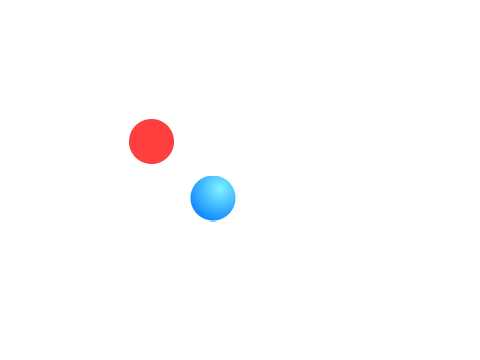
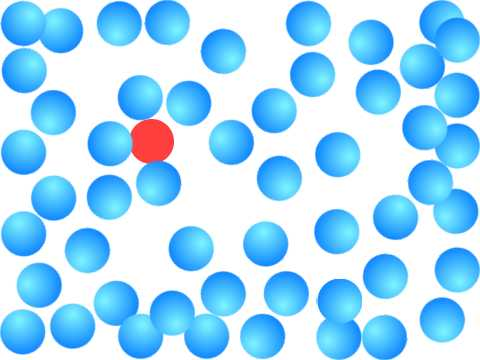
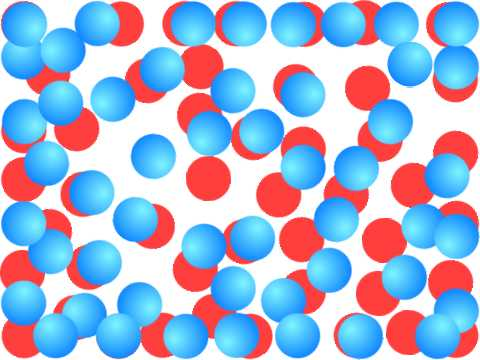
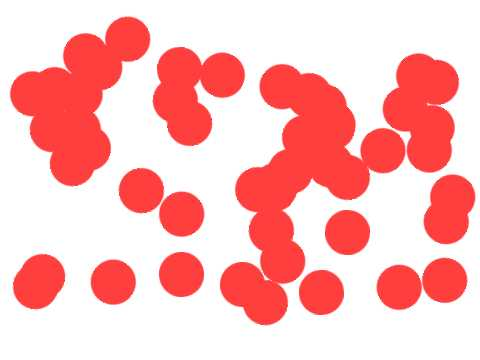
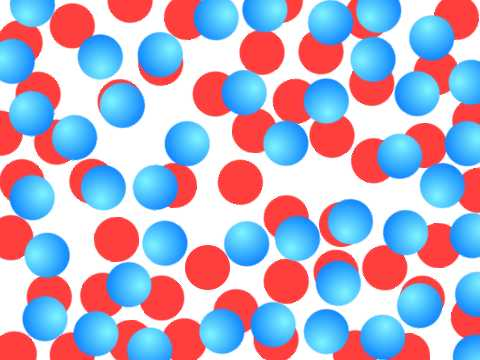
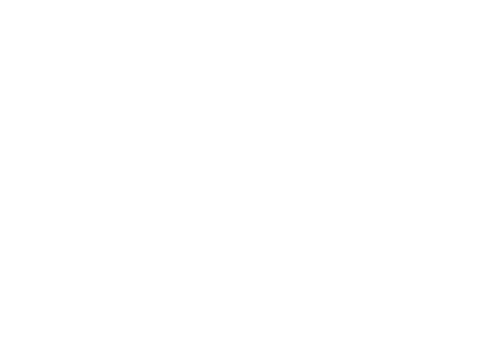
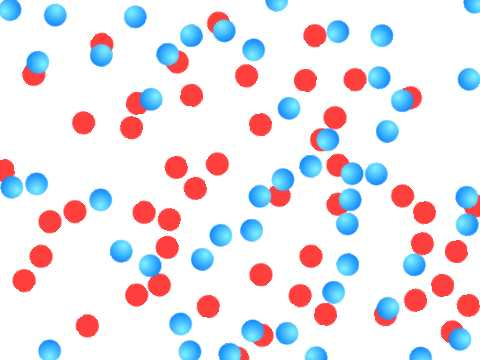
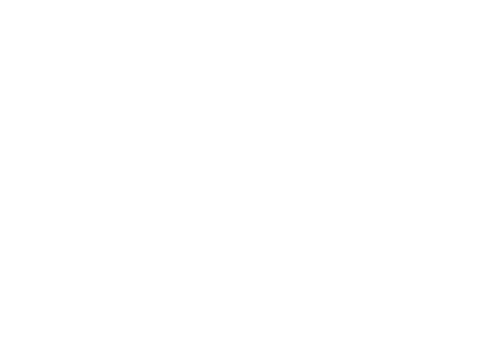

In [89]:
#Adicionando as imagens do palco ao Gráfico 1

#Filtrando as imagens do palco salvas para o projeto selecionado e definindo quantas imagens serão adicionas ao Gráfico 1
df_img = df[(df.projectID == selected_projectID) & (~df.filename.isnull())][[time_type, 'filename']]
df_img.columns = ['time', 'data']
df_img = df_img.reset_index(drop = True)
qty_img = 5

if not df_img.empty:
    #lista baseada na posição da imagem no DataFrame
    step = int((len(df_img) - 1) / (qty_img - 1))
    img_list_pos = []
    img_list_pos.append(0)
    for i in range(1, qty_img - 1):
        img_list_pos.append(step * i)
    img_list_pos.append(len(df_img) - 1)

    #Lista baseada no tempo da imagem no DataFrame
    initial_img_time = df_img['time'].iloc[0]
    end_img_time = df_img['time'].iloc[len(df_img) - 1]
    step = int((end_img_time - initial_img_time) / (qty_img - 1))
    time_list = []
    time_list.append(initial_img_time)
    for i in range(1, qty_img - 1):
        img_time_ref = initial_img_time + step * i
        img_time_ant = df_img[df_img.time <= (img_time_ref)][['time']].max().iloc[0]
        img_time_pos = df_img[df_img.time >= (img_time_ref)][['time']].min().iloc[0]
        img_time = img_time_ant
        if (img_time_pos - img_time_ref) < (img_time_ref - img_time_ant):
            img_time = img_time_pos
        if img_time not in time_list:
            time_list.append(img_time)
    time_list.append(end_img_time)
    img_list_time = df_img.index[df_img['time'].isin(time_list)].to_list()

    #Substituir no for abaixo qual lista quer usar: img_list_pos ou img_list_time
    #file_zip = zipfile.ZipFile(path + '\\' + selected_projectID + '.sb3', 'r')
    for i in img_list_time:
        #screenshot = base64.b64encode(file_zip.read(df_img['data'].iloc[i]))
        screenshot = base64.b64encode(open(path + '\\' + selected_projectID + '\\' + df_img['data'].iloc[i], 'rb').read())
        fig.add_layout_image(
            {'source': 'data:image/jpg;base64,{}'.format(screenshot.decode()),
             'xref': 'x',
             'yref': 'paper',
             'x': df_img['time'].iloc[i],
             'y': 1.05,
             'sizex': 300,
             'sizey': 0.1,
             'xanchor': 'right', 
             'yanchor': 'bottom'})

fig.update_layout(
    autosize = False,
    height = 500,
    width = 900,
    margin = {'r': 10, 'l': 10, 'b': 10, 't': 140})

fig.show()

In [90]:
#ajustando para as barras ficarem na mesma altura que o maior número de blocos usados do Gráfico 2
max_blocks = df_blocks.qty_blocks.max()
size_adjust = max_blocks / bar_height
df_events_SVGSkin['data'] = df_events_SVGSkin['data'] * size_adjust
df_events_blockdrag['data'] = df_events_blockdrag['data'] * size_adjust
df_events_run_zero['data'] = df_events_run_zero['data'] * size_adjust
df_events_run_not_zero['data'] = df_events_run_not_zero['data'] * size_adjust

In [91]:
#Gráfico 2
fig2 = go.Figure()

fig2.add_trace(
    go.Scatter(
        x = df_events_run_not_zero.time,
        y = df_events_run_not_zero.data,
        mode = 'lines',
        name = 'Running (>0s)',
        fill = "tozeroy",
        line = {'color': run_not_zero_color, 'width': 0, 'shape': 'hv'}))

fig2.add_trace(
    go.Scatter(
        x = df_events_SVGSkin.time,
        y = df_events_SVGSkin.data,
        name = 'Editing Backdrop/Costume/Sprite',
        mode = 'lines',
        fill = "tozeroy",
        line = {'color': SVGSkin_color, 'width': 0, 'shape': 'hv'}))

fig2.add_trace(
    go.Bar(
        x = df_events_run_zero.time,
        y = df_events_run_zero.data,
        width = bar_width,
        marker = {'line': {'width': 0}, 'color': run_zero_color},
        name = 'Running (0s)'))

fig2.add_trace(
    go.Bar(
        x = df_events_blockdrag.time,
        y = df_events_blockdrag.data,
        width = bar_width,
        marker = {'line': {'width': 0}, 'color': blockdrag_color},
        name = 'Block drag'))

fig2.add_trace(
    go.Scatter(
        x = df_events_blocks.time,
        y = df_events_blocks.data,
        mode = 'lines',
        name = 'Blocks used',
        line = {'color': 'black', 'width': 2, 'shape': 'hv'}))

fig2.update_layout(
    showlegend = True, 
    plot_bgcolor = 'rgba(0,0,0,0)',
    title = {
        'text': 'ProjectID ' + selected_projectID,
        'font_size': 20,
        'xanchor': 'center',
        'x': 0.5})

In [92]:
#precisa instalar o kaleido, pode ser via pip ou via conda:
#via pip
#pip install -U kaleido
#via conda
#conda install -c conda-forge python-kaleido
fig.write_image(path + '\\graficos\\grafico_' + selected_projectID + '.svg')
fig.write_image(path + '\\graficos\\grafico_' + selected_projectID + '.pdf')
fig2.write_image(path + '\\graficos\\grafico2_' + selected_projectID + '.svg')
fig2.write_image(path + '\\graficos\\grafico2_' + selected_projectID + '.pdf')

In [93]:
#Gráfico 3
#projects_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
projects_list = df['projectID'].drop_duplicates().tolist()
projects_list = natural_sort(projects_list)

time_type = 'adjusted_time'
if use_minutes:
    time_type += '_min'

rows_max = 6
rows_num = len(projects_list) if len(projects_list) < rows_max else rows_max
cols_num = ceil(len(projects_list) / rows_max)

subplot_titles = [''] * (rows_num * cols_num)

i = 0
for project in projects_list:
    subplot_titles[i] = 'ProjectID ' + project
    i += cols_num
    if (i + 1) > (rows_num * cols_num):
        i = (i + 1) % (rows_num * cols_num)

fig3 = go.Figure()
fig3 = make_subplots(
    rows = rows_num,
    cols = cols_num,
    shared_xaxes = True,
    vertical_spacing = 0.05,
    subplot_titles = (subplot_titles))

max_time = 0
i = 1
for project in projects_list:
    
    selected_projectID = project
    fill_df_events()
    
    max_ID_time = df[df.projectID == selected_projectID][['projectID', time_type]].groupby(['projectID']).agg(['max']).iloc[0]
    max_ID_time = ceil(max_ID_time)
    if max_ID_time > max_time:
        max_time = max_ID_time
    
    add_legends = False
    if i == 1:
        add_legends = True
    
    row_i = i % rows_max if i % rows_max != 0 else rows_max
    col_j = ceil(i / rows_max)
    
    max_blocks = df_blocks.qty_blocks.max()
    size_adjust = max_blocks / bar_height
    df_events_SVGSkin['data'] = df_events_SVGSkin['data'] * size_adjust
    df_events_blockdrag['data'] = df_events_blockdrag['data'] * size_adjust
    df_events_run_zero['data'] = df_events_run_zero['data'] * size_adjust
    df_events_run_not_zero['data'] = df_events_run_not_zero['data'] * size_adjust

    fig3.add_trace(
        go.Scatter(
            x = df_events_run_not_zero.time,
            y = df_events_run_not_zero.data,
            mode = 'lines',
            name = 'Running (>0s)',
            fill = "tozeroy",
            line = {'color': run_not_zero_color, 'width': 0, 'shape': 'hv'},
            showlegend = add_legends),
    row = row_i, col = col_j)
    
    fig3.add_trace(
        go.Scatter(
            x = df_events_SVGSkin.time,
            y = df_events_SVGSkin.data,
            name = 'Editing Backdrop/Costume/Sprite',
            mode = 'lines',
            fill = "tozeroy",
            line = {'color': SVGSkin_color, 'width': 0, 'shape': 'hv'},
            showlegend = add_legends),
    row = row_i, col = col_j)
    
    fig3.add_trace(
        go.Bar(
            x = df_events_run_zero.time,
            y = df_events_run_zero.data,
            width = bar_width,
            marker = {'line': {'width': 0}, 'color': run_zero_color},
            name = 'Running (0s)',
            showlegend = add_legends),
    row = row_i, col = col_j)

    fig3.add_trace(
        go.Bar(
            x = df_events_blockdrag.time,
            y = df_events_blockdrag.data,
            width = bar_width,
            marker = {'line': {'width': 0}, 'color': blockdrag_color},
            name = 'Block drag',
            showlegend = add_legends),
    row = row_i, col = col_j)
    
    fig3.add_trace(
        go.Scatter(
            x = df_events_blocks.time,
            y = df_events_blocks.data,
            mode = 'lines',
            name = 'Blocks used',
            line = {'color': 'black', 'width': 2, 'shape': 'hv'},
            showlegend = add_legends),
    row = row_i, col = col_j)

    i += 1

fig3.update_layout(
    showlegend=True,
    plot_bgcolor='rgba(0,0,0,0)',
    legend={
        'orientation': 'h',
        'yanchor': 'bottom',
        'y': -0.1,
        'xanchor': 'center',
        'x': 0.5},
    font={'size': 8},
    title={
        'text': 'Comparing Projects',
        'font_size': 20,
        'xanchor': 'center',
        'x': 0.5})

fig3.update_xaxes(range=[0, int(max_time)])

for i in range(len(projects_list)):
#     fig3.layout.annotations[i].update(xanchor='left')
#     fig3.layout.annotations[i].update(x=-0.02)
    fig3.layout.annotations[i].update(font_size = 12)

fig3.update_layout(
    autosize = False,
    height = 800,
    width = 1500,
    margin = {'r': 10, 'l': 10, 'b': 10, 't': 100})

fig3.show()

In [94]:
fig3.write_image(path + '\\graficos\\grafico3.svg')
fig3.write_image(path + '\\graficos\\grafico3.pdf')